# Project Pyreidolia - AA 12/12/2021

In [27]:
#Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Setup the graph options:
import scicomap as sc
import matplotlib as mpl
sc_map = sc.ScicoSequential(cmap='tropical')
sc_map.unif_sym_cmap(lift=None, 
                     bitonic=False, 
                     diffuse=True)
sc_cmap = sc_map.get_mpl_color_map()

mpl.cm.register_cmap("tropical", sc_cmap)

## Functions:

**`Cloud_count_per_label(x)`**: guess the number of guess the "number of clouds" (separate segments inside each label mask corresponding to different cloud structures). The function has methods to detect clouds that can be separated horizontly and vertically. The horizontal differentiation is maid by looking for pixel jumps `> 1400*2`. The vertical search is conducted by assessing the y values of the start and end of the segments belonging to the same x value. Additional caveats were included to deal with isolated pixels (for horizontal search), clouds that take up the whole y range (for horizontal search), differentiate between two clouds and a single irregular shaped cloud (for vertical search), differentiate between three clouds and a two irregular shaped clouds (for vertical search), discard segments with really low height / isolated pixels (for vertical search).  

I found 3 conditions that aren't taken into account and cause errors in the `Cloud_Count` variable: 1) isolated pixels really near an actual cloud (I'm also discarding the cloud atm); 2) irregularities in the shape of the right side of the clouds; 3) 2 or more vertically aligned clouds that are in contact with the right image border (needed to get to the end of the clouds to deect them).  

This function can be applied (using `df.EncodedPixels.apply(get_number_labels)` ) to the original feature `EncodedPixels` to generate the `Cloud_Count` feature. **Returns:** number of clouds.

In [71]:
def Cloud_count_per_label(x):
    
    #Check if x is a float:
    if isinstance(x, float): 
        #'EncodedPixels' is Nan (meaning no cloud for the given type)
        return 0
    else: #when there are clouds for a given type, the type(x) is a string (of pixels / distances)
        #Create list of each element of 'EncodedPixels' separated by " "
        #EncodedPixels : 'px1 len1 px2 len2 ...' (need to convert to integer)
        L = x.split(" ")         #L : ['px1', 'len1', 'px2', 'len2', ...]
        L = [int(i) for i in L]  #L : [px1, len1, px2, len2, ...]

        L_px = L[0::2]      #only pxs [px1, px2, ...]
        L_px_dist = L[1::2] #only px distances/lenghts [len1, len2, ...]
        
        L_px_1 = []
        L_px_1.extend(L_px)
        L_px_1.pop(len(L_px_1)-1)

        L_px_2 = []
        L_px_2.extend(L_px)
        L_px_2.pop(0)

        #Create list with element differences:
        #L_diff = np.subtract(np.array(L[1:len(L_px)]), np.array(L[0:len(L_px) - 1]))
        L_diff = np.subtract(np.array(L_px_2), np.array(L_px_1))
        L_diff = L_diff.tolist()
        #L_diff : [px2-px1, px3-px2, ...]

        new_cloud_structure_count = 0
        new_cloud_structure_idx = []
        
        #Keep track of the x,y values of the pixels:
        L_x_start = []  #convert starting x pixels 
        L_x_end = []    #convert the start + distance x pixels
        L_y_start = []  #convert the starting y pixels
        L_y_end = []    #convert the start + distance y pixels
        #NOTE: the index -1 will be associated with the most recent values
        
        
        #Scan pixel diffs. for anomalies:
        for idx_diff in range(0, len(L_diff)-1):
            
            #CHANGES THAT OCCUR HORIZONTALLY: (e.g. you can separate the clouds 
            #with a x = c affine function)
            #If there's a jump bigger than x2 resolution height:
            if L_diff[idx_diff] > 1400*2:
                
                #Results of adding this restriction:
                    # lots of extreme values (max = 32)
                
                #NEW CODE [1]: Special case: mask segment loops around the image borders:
                    #check if the pixel distance justifies this:
                if L_px[idx_diff] + L_px_dist[idx_diff] != (L_px[idx_diff+1] -1): #!= -> doesn't justify
                    
                    #Results of adding this restriction: 
                        # Cloud_Count looks better with this (no extreme values, max = 6)
                        
                    #NEW CODE [2]: found isolated pixels in the middle of the dark patch...
                    #Example: 95a1be9.jpg, Fish as 4 isolated patches of pixels, totaling in Cloud_Count=6 
                        #check if height of next segment is not residual (> 35):
                    if L_px_dist[idx_diff+1] > 35:
                        
                        ##Results of adding this restriction:
                            # Even better distribution (max = 4)
                            # Only one of the graphs doesn't align with the Cloud_Count value
                        
                        new_cloud_structure_count += 1
                        new_cloud_structure_idx.append(idx_diff+1)
                        
                        
            #CHANGES THAT OCCUR VERTICALLY: (e.g. you can separate the clouds 
            #with a y = c affine function)
            
            #Get x value of start and end pixels in each segment:
            x_start = np.floor((L_px_1[idx_diff]) / 1400)
            L_x_start.append(x_start)
            x_end = np.floor((L_px_1[idx_diff]+L_px_dist[idx_diff]) / 1400)
            L_x_end.append(x_end)
            
            #Get y values for the start and end pixels in each segment:
            y_start = L_px_1[idx_diff] % 1400
            L_y_start.append(y_start)
            y_end = (L_px_1[idx_diff]+L_px_dist[idx_diff]) % 1400
            L_y_end.append(y_end)
            
            #The objective is to look for sequential segments that have the same x value
            #(occur in the same vertical line), possibily indicating that multiple
            #segments exist. This is not a given though, since two distinct segments
            #might just be a consequence of irregular shaped cloud structure. 
            #To differentiate between these cases, we need to evaluate the y values
            #of the segments with the same x value. For instance, when 2 segments
            #with same x occur sequentially, followed by just a segment at x+1, 
            #it's possible to infer that these were two clouds if: 
            #         y1 y1 y1 y1 y1 Y1 Y1 Y1 Y1 Y1 
            #         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
            #         y2 y2 y2 y2 y2 Y2 Y2 Y2 Y2 Y2
            #
            #     y3 y3 y3 y3 y3 y3
            #     ~~~~~~~~~~~~~~~~~   
            #     y4 y4 y4 y4 y4 y4
            
            #        y3 < Y2, in this case. 
            #        (remember that Y2 could have been =y4, if this was just an irregular cloud structure.)
            
            
            #Since we evaluating differences in the number of sequential segments with the same x value
            #across the two most recent x values, I can only apply this logic if idx_diff >= 2.
            if idx_diff >= 1:
                
                aux = True    #Control variable
                idx_aux = -1  #Index used to select the most recent x value
                current_x = 1
                
                #Look for current x value -> might still be future segments with this value. Thus
                #I'm going to wait for this xto be complete, and only do the analysis for
                #the next 2 x's.
                #Find sequential segments with the same x value (most recent x value in the data).
                #Make sure we don't overextend the list index (might happen for
                #the first pixel segments of EncodedPixels) -> -(idx_aux -1) < len(L_x)
                while (aux and -(idx_aux -1) < len(L_x_start)):
                    
                    #If two sequential segments have the same x values:
                    #(all start and end points have the same x value)
                    if L_x_start[idx_aux] == L_x_start[idx_aux -1] and L_x_end[idx_aux] == L_x_end[idx_aux -1] and L_x_start[idx_aux] == L_x_end[idx_aux -1]:
                        current_x += 1
                        idx_aux -= 1 #increment to see if the next segment also has the same x in the next while iter.
                    #The segment doesnt have the same x value:
                    else:
                        #Break the loop. The search for sequential segment with the same x is over.
                        aux = False
                
                idx_aux -= 1 #Continue scanning in the next x value
                aux = True   #Reset control variable
                same_x = 1    #Initialize same_x
                
                #Find sequential segments with the same x value (second x value found).
                #Same thing, only starting where we ended in the previous while loop.
                #Make sure we don't overextend the list index (might happen for
                #the first pixel segments of EncodedPixels) -> -(idx_aux -1) < len(L_x)
                while (aux and -(idx_aux -1) < len(L_x_start)):
                    
                    #If two sequential segments have the same x values:
                    #(all start and end points have the same x value)
                    if L_x_start[idx_aux] == L_x_start[idx_aux -1] and L_x_end[idx_aux] == L_x_end[idx_aux -1] and L_x_start[idx_aux] == L_x_end[idx_aux -1]:
                        same_x += 1 #found one more segment with the same x value
                        idx_aux -= 1     #increment to see if the next segment also has the same x in the next while iter.
                        
                    #The segment doesnt have the same x value:
                    else:
                        #Break the loop. The search for sequential segment with the same x is over.
                        aux = False
                        
                idx_aux -= 1 #Continue scanning in the next x value
                aux = True   #Reset control variable
                same_x_prev = 1  #Initialize same_x_prev
                        
                while (aux and -(idx_aux -1) < len(L_x_start)):
                    
                    #If two sequential segments have the same x values:
                    #(all start and end points have the same x value)
                    if L_x_start[idx_aux] == L_x_start[idx_aux -1] and L_x_end[idx_aux] == L_x_end[idx_aux -1] and L_x_start[idx_aux] == L_x_end[idx_aux -1]:
                        same_x_prev += 1 #found one more segment with the same x value
                        idx_aux -= 1     #increment to see if the next segment also has the same x in the next while iter.
                        
                    #The segment doesnt have the same x value:
                    else:
                        #Break the loop. The search for sequential segment with the same x is over.
                        aux = False
                
                 
                
                #If same_x < same_x_prev potentially a new cloud structure (see example).
                #But might be just an irregular shpaed cloud. Check y values to be sure:
                if same_x == same_x_prev -1:
                    #by doing this and not same_x < same_x_prev and skiping the cases
                    #where there are, fro instance, 3 segments with x_same_prev
                    #and only 1 with x_same:
                    
                    #Get list of start/end y values for the current x
                    L_y_of_same_x = []
                    L_y_of_same_x = L_y_of_same_x + [L_y_start[i] for i in range(-current_x-1, -current_x-same_x-1, -1)]
                    L_y_of_same_x = L_y_of_same_x + [L_y_end[i] for i in range(-current_x-1, -current_x-same_x-1, -1)]
                    L_y_of_same_x.sort(reverse=True)

                    #Get list of start/end y values for the previous x
                    L_y_of_same_x_prev = []
                    L_y_of_same_x_prev = L_y_of_same_x_prev + [L_y_start[i] for i in range(-current_x-same_x-1, -current_x-same_x_prev - same_x - 1, -1)]
                    L_y_of_same_x_prev = L_y_of_same_x_prev + [L_y_end[i] for i in range(-current_x-same_x-1, -current_x-same_x_prev -same_x - 1, -1)]
                    L_y_of_same_x_prev.sort(reverse=True)
                    
                    #NOTE: instead of generalizing for n vertically overlapping images, I'm just gonna do
                    #the math for 2 and 3 vertically overlapping images. This should cover most cases ...
                    
                    
                    if same_x_prev == 2 and L_y_start[-1] != L_y_start[-2]:  #just started a new x value.
                        #2 situations:
                        # ~~~~~~~         or       ~~~~~~~~~
                        #     ~~~~~~~~         ~~~~~~~~
                        
                        #NEW CODE: differences need to be bigger than 35 pixels:
                        #Filter out isolated pixels (mask bugs)
                        aux2 = True
                        for y_idx in range(0, len(L_y_of_same_x)-1):
                            if abs(L_y_of_same_x[y_idx] - L_y_of_same_x[y_idx+1]) < 35:
                                aux2 = False
                        for y_idx in range(0, len(L_y_of_same_x_prev)-1):
                            if abs(L_y_of_same_x_prev[y_idx] - L_y_of_same_x_prev[y_idx+1]) < 35:
                                aux2 = False
                        
                        if (L_y_of_same_x_prev[1] > L_y_of_same_x[0] or L_y_of_same_x_prev[2] < L_y_of_same_x[1]) and aux2:
                            
                            #Check if the previous increment in the number of segments with the
                            #same x value is valid:
                            new_cloud_structure_count += 1
                        
                    if same_x_prev == 3 and L_y_start[-1] != L_y_start[-2]: #just started a new x value.
                        #3 situations:
                        # ~~~~~~~         or       ~~~~~~~~~   or      ~~~~~~~~~~
                        #     ~~~~~~~~         ~~~~~~~~                ~~~~~~~~~~
                        #     ~~~~~~~~             ~~~~~~~~~       ~~~~~~~~~~   
                        
                        #NEW CODE: differences need to be bigger than 35 pixels:
                        #Filter out isolated pixels (mask bugs)
                        aux2 = True
                        for y_idx in range(0, len(L_y_of_same_x)-1):
                            if L_y_of_same_x[y_idx] - L_y_of_same_x[y_idx+1] < 35:
                                aux2 = False
                        for y_idx in range(0, len(L_y_of_same_x_prev)-1):
                            if L_y_of_same_x_prev[y_idx] - L_y_of_same_x_prev[y_idx+1] < 35:
                                aux2 = False
                        
                        if L_y_of_same_x_prev[1] > L_y_of_same_x[0] and aux2:
                            new_cloud_structure_count += 1
                        elif L_y_of_same_x_prev[2] < L_y_of_same_x[1] and L_y_of_same_x_prev[3] > L_y_of_same_x[2] and aux2:
                            new_cloud_structure_count += 1
                        elif L_y_of_same_x_prev[4] < L_y_of_same_x[3] and aux2: 
                            new_cloud_structure_count += 1
                            
        return new_cloud_structure_count +1 #+1 to count the original cloud
#Test the function (example):
#df['Cloud_Count'] = df.EncodedPixels.apply(Cloud_Count_per_label)

**`Graph_label_masks_from_image_list(image_list, path, df)`**: from a list of images `image_list` stored in a `path`, create a graph for each image with label pixel masks overlayed with the respective image. The `df` is used to generate the `Cloud_Label` feature and to obtain the `EncodedPixels` for each cloud label (used to create the matrix arrays for plotting). **Returns:** no return.

In [75]:
def Graph_label_masks_from_image_list(image_list, path, df):
    
    #Just in case df doesnt have it, create the Cloud_Label column (to be used as a graphical label):
    #df['Image_File'] = df['Image_Label'].apply(lambda x: x.split("_")[0])
    df['Cloud_Label'] = df['Image_Label'].apply(lambda x: x.split("_")[1])
    
    #Cycle through every image in image_list:
    for image in image_list: 
        
        #Read the image from path. The image will be used as a background:
        img = plt.imread(path + "\\" + image)
        fig, ax = plt.subplots(figsize=(14,14)) #(14,14) dimensions seem reasonable...
        ax.imshow(img, extent=[0,2100,1400,0])  #extent=[0,2100,1400,0] is just to "freeze" the graph dimensions
        
        #Note that the images are 1400x2100, and the pixels start counting top->bottom/left->right
        #(see axis orientations of a given image plot using this present function).
        
        plt.title('Image: '+image, loc='left', fontsize = 'xx-large')
        
        #Temporary DataFrame (df1) with only the image data (4 rows, each correspond to one cloud label type):
        df1 = df[df.Image_File == image]
    
        #Cycle through the 4 cloud labels:
        for j in range(0,4):
            
            #Select the data of the cloud label associated with index j:
            seg = df1.iloc[j,:]
            
            #The j cloud label might not have associated clouds for a given image. 
            #When this happens, seg.EncodedPixels is Nan (type = float). I'm
            #going to skip the label if this is the case (no pixel data to graph):
            if isinstance(seg.EncodedPixels, float): 
                
                #'EncodedPixels' is Nan (meaning no cloud for the given type).
                #Continue to next label.
                continue 
            else: #when there are clouds for a given type, the type(seg.EncodedPixels) is a string (of pixels / distances)
                
                L = seg.EncodedPixels.split(" ")   #L : ['px1', 'len1', 'px2', 'len2', ...]
                L = [int(i) for i in L]            #L : [px1, len1, px2, len2, ...]

                L_px = L[0::2]      #only pxs [px1, px2, ...]
                L_px_dist = L[1::2] #only px distances [len1, len2, ...]
                
                #Lists of x,y to be used in the plots:
                L_px_x = []
                L_px_y = []
                
                #Loop through every starting pixel index in L_px:
                for idx in range(0, len(L_px)):
                    px = L_px[idx] #actual pixel value
                    
                    #Get the pixels values from px to px+L_px_dist[idx]. This list of pixels
                    #will be used in the plot functions. In theroy, to get all the pixels the
                    #step of the range should be "range(0, L_px_dist[idx],1)". But, for plotting
                    #purposes, an increment of 3 is sufficient to visualize the area/shape
                    #of the cloud label mask (and this step runs three times faster).
                    for delta in range(0, L_px_dist[idx],3):
                        #Every 1400 pixels the x increments by 1:
                        x = np.floor((px+delta) / 1400)
                        #The remaider is the pixels along the y axis:
                        y = (px+delta) % 1400
                        
                        L_px_x.append(x)
                        L_px_y.append(y)
                
                #For a better comprehension, I'm going to give text labels to each cloud label mask.
                #Going to plot them in the "top left corner" of each mask:
                x_min = L_px_x[0]
                y_min = L_px_y[0]
                
                #The mask plots going to have some transperency to see the background image:
                if seg.Cloud_Label == 'Sugar':
                    ax.scatter(L_px_x, L_px_y, marker='s', s=1.5, alpha=0.02, c='orange') #label mask
                    txt = ax.text(x_min, y_min, s='Sugar', size=15, color='#FFEBCD', fontweight='heavy') #label text
                    txt.set_bbox(dict(facecolor='orange', alpha=0.5, edgecolor='orange')) #label text properties
                elif seg.Cloud_Label == 'Gravel':
                    ax.scatter(L_px_x, L_px_y, marker='s', s=1.5, alpha=0.02, c='green') #label mask
                    txt = ax.text(x_min, y_min, s='Gravel', size=15, color='#F0FFF0', fontweight='heavy') #label text
                    txt.set_bbox(dict(facecolor='green', alpha=0.5, edgecolor='green')) #label text properties
                elif seg.Cloud_Label == 'Fish':
                    ax.scatter(L_px_x, L_px_y, marker='s', s=1.5, alpha=0.02, c='blue') #label mask
                    txt = ax.text(x_min, y_min, s='Fish', size=15, color='#E0FFFF', fontweight='heavy') #label text
                    txt.set_bbox(dict(facecolor='blue', alpha=0.5, edgecolor='blue')) #label text properties
                else:
                    ax.scatter(L_px_x, L_px_y, marker='s', s=1.5, alpha=0.02, c='red') #label mask
                    txt = ax.text(x_min, y_min, s='Flower', size=15, color='#FFF5EE', fontweight='heavy') #label text
                    txt.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red')) #label text properties
        plt.show() #force show. fig and ax will be reset for the next image.
        
#Test the function (example):
#image_list = ['0011165.jpg', '002be4f.jpg']
#path = r'C:\Users\e400086\Desktop\Docs\DS_Certificate_Sorbonne_and_CV\02_Project_Cloud_Regions\01_Data\train_images'
#Graph_label_masks_from_image_list(image_list, path, df)

**`Imgs_w_cloud_count_val(df, cloud_count_val, n_img)`**: filter the `df` by `Cloud_Count == cloud_count_val`, in order to get `n_img` images and the corresponding cloud labels that have the specified cloud count in each image. Note that this functions assumes that df already has a Cloud_Count and Image_File features. **Returns:** list of images (strings, `shape=[n_img]`, or lower if not enough images exist with `Cloud_Count == cloud_count_val`) and a list of cloud labels (strings, `shape=[n_img]`, or lower if not enough images exist with `Cloud_Count == cloud_count_val`).

In [4]:
def Imgs_w_cloud_count_val(df, cloud_count_val, n_img):
    
    #Note: this functions assumes that df already has a Cloud_Count and Image_File features.
    
    #Objective: filter df by Cloud_Count = cloud_count_val and obtain n_img images. This
    #function returns a list with these images (e.g. ['0011165.jpg', '002be4f.jpg', '0031ae9.jpg']),
    #and a list of cloud labels that infact have the specified cloud count in each image.
    
    #There are 4 rows in df for each image. Thus, worst case scenario I need
    #to scan n_img*4 lines, in order to obtain n_img unique images from a df
    #filtered by only rows with Cloud_Count = cloud_count_val (in other words, 
    #the worst case scenario happens when all labels in all filtered images
    #have Cloud_Count = cloud_count_val).
    #A special case appears when we are dealing with cloud_count_val values
    #that occur seldomly in df. If the df filteres by rows only with 
    #Cloud_Count = cloud_count_val has (#rows) < n_img*4, then I'm going to
    #cycle only through the rows I have available. If these aren't enough
    # to obtain n_img images, output only the images that I got.
    
    for n_row in range(1, min(n_img*4, len(df[df.Cloud_Count == cloud_count_val])) +1):
        
        L_img = df[df.Cloud_Count == cloud_count_val].iloc[0:n_row,:].Image_File.value_counts(sort=False, ascending=True).index.tolist()
        #Need to sort by Image_File to synchronize with the Cloud_Label values
        L_img.sort(reverse=False) #equivalent to ascending = True in pandas
        
        if len(L_img) == n_img or n_row == min(n_img*4, len(df[df.Cloud_Count == cloud_count_val])):
            
            #Get the labels:
            #From these images, get list of the cloud labels that infact have the Cloud_Count = cloud_count_val:
            df_temp = df[df.Cloud_Count == cloud_count_val].iloc[0:n_row,:]
            
            #Get the first situation in each image in which Cloud_Count = cloud_count_val:
            # (there could be more than one cloud label per image with Cloud_Count == cloud_count_val)
            df_temp = df_temp.groupby('Image_File').first() 
            
            #Apply the same sort (by Image_File, ascending), and list Cloud_Label values:
            L_img_labels = list(df_temp.sort_values(by='Image_File', ascending=True).Cloud_Label)
            
            return L_img, L_img_labels
        
    return "Error: check cloud_count_val and n_img values."
#Test the function (example):
# L_img, L_img_labels = Imgs_w_Cloud_count_val(df, 0, 3)
# print(">> Cloud_Count = 0:", L_img, L_img_labels)

## Preprocessing:

In [5]:
#Path and file:
db_path = r"C:\Users\e400086\Desktop\Docs\DS_Certificate_Sorbonne_and_CV\02_Project_Cloud_Regions\01_Data\\"
file = "train.csv"
pd.set_option("max_colwidth", 100)
#pd.set_option("max_colwidth", 15000) #to see all pixel segments per cloud type
df = pd.read_csv(db_path+file)
print(df.info())
df.head(17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22184 entries, 0 to 22183
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Label    22184 non-null  object
 1   EncodedPixels  11836 non-null  object
dtypes: object(2)
memory usage: 346.8+ KB
None


Image_Label  \
0     0011165.jpg_Fish   
1   0011165.jpg_Flower   
2   0011165.jpg_Gravel   
3    0011165.jpg_Sugar   
4     002be4f.jpg_Fish   
5   002be4f.jpg_Flower   
6   002be4f.jpg_Gravel   
7    002be4f.jpg_Sugar   
8     0031ae9.jpg_Fish   
9   0031ae9.jpg_Flower   
10  0031ae9.jpg_Gravel   
11   0031ae9.jpg_Sugar   
12    0035239.jpg_Fish   
13  0035239.jpg_Flower   
14  0035239.jpg_Gravel   
15   0035239.jpg_Sugar   
16    003994e.jpg_Fish   

                                                                                          EncodedPixels  
0   264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 9...  
1   1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 13653...  
2                                                                                                   NaN  
3                                                                                                   NaN  
4   233813 878 235213 878 236613 878 238010 881 239410 881 240810 881 242210 881 243610 881 245010 8...  
5   1339279 519 1340679 519 1342079 519 1343479 519 1344879 519 1346279 519 1347679 519 1349079 519 ...  
6                                                                                                   NaN  
7   67495 350 68895 350 70295 350 71695 350 73095 350 74495 350 75895 350 77295 350 78695 350 80095 ...  
8   3510 690 4910 690 6310 690 7710 690 9110 690 10510 690 11910 690 13310 690 14710 690 16110 690 1...  
9   2047 703 3447 703 4847 703 6247 703 7647 703 9047 703 10447 703 11847 703 13247 703 14647 703 16...  
10                                                                                                  NaN  
11  658170 388 659570 388 660970 388 662370 388 663770 388 665170 388 666570 388 667970 388 669370 3...  
12                                                                                                  NaN  
13  100812 462 102212 462 103612 462 105012 462 106412 462 107812 462 109212 462 110612 462 112012 4...  
14  65400 380 66800 380 68200 380 69600 380 71000 380 72400 380 73800 380 75200 380 76600 380 78000 ...  
15                                                                                                  NaN  
16  2367966 18 2367985 2 2367993 8 2368002 62 2369365 20 2369388 11 2369401 1 2369403 61 2370764 13 ...

In [6]:
#New features [1]:
#  -> Image_File: image name + extension (ex: '0011165.jpg')
#  -> Cloud_Label: the cloud label 
df['Image_File'] = df['Image_Label'].apply(lambda x: x.split("_")[0])
df['Cloud_Label'] = df['Image_Label'].apply(lambda x: x.split("_")[1])

print(">> Cloud type classes: "+str(df['Cloud_Label'].unique()))
print(">> Number of images in the Train set: "+str(df['Image_File'].nunique()))

>> Cloud type classes: ['Fish' 'Flower' 'Gravel' 'Sugar']
>> Number of images in the Train set: 5546


In [72]:
#New features [2]: 
#  -> Cloud_Count: guess the "number of clouds" (separate segments inside each label mask corresponding
#     to different cloud structures). Need to apply a function to EncodedPixels to get this feature.
df['Cloud_Count'] = df.EncodedPixels.apply(Cloud_count_per_label)

print(">> Cloud_Count values:", df.Cloud_Count.value_counts(sort=False), sep='\n')
#The number of cloud labels with 0 clouds shoud be equal to the number of Nan of EncodedPixels:
print(">> (Check 0 values logic): ", df.EncodedPixels.isna().sum())

#See how the df looks like now:
df

>> Cloud_Count values:
0    10348
1    10680
2     1117
3       35
4        4
Name: Cloud_Count, dtype: int64
>> (Check 0 values logic):  10348


Image_Label  \
0        0011165.jpg_Fish   
1      0011165.jpg_Flower   
2      0011165.jpg_Gravel   
3       0011165.jpg_Sugar   
4        002be4f.jpg_Fish   
...                   ...   
22179   ffd6680.jpg_Sugar   
22180    ffea4f4.jpg_Fish   
22181  ffea4f4.jpg_Flower   
22182  ffea4f4.jpg_Gravel   
22183   ffea4f4.jpg_Sugar   

                                                                                             EncodedPixels  \
0      264918 937 266318 937 267718 937 269118 937 270518 937 271918 937 273318 937 274718 937 276118 9...   
1      1355565 1002 1356965 1002 1358365 1002 1359765 1002 1361165 1002 1362565 1002 1363965 1002 13653...   
2                                                                                                      NaN   
3                                                                                                      NaN   
4      233813 878 235213 878 236613 878 238010 881 239410 881 240810 881 242210 881 243610 881 245010 8...   
...                                                                                                    ...   
22179                                                                                                  NaN   
22180                                                                                                  NaN   
22181  1194860 675 1196260 675 1197660 675 1199060 675 1200460 675 1201860 675 1203260 675 1204660 675 ...   
22182                                                                                                  NaN   
22183                                                                                                  NaN   

        Image_File Cloud_Label  Cloud_Count  
0      0011165.jpg        Fish            1  
1      0011165.jpg      Flower            1  
2      0011165.jpg      Gravel            0  
3      0011165.jpg       Sugar            0  
4      002be4f.jpg        Fish            1  
...            ...         ...          ...  
22179  ffd6680.jpg       Sugar            0  
22180  ffea4f4.jpg        Fish            0  
22181  ffea4f4.jpg      Flower            1  
22182  ffea4f4.jpg      Gravel            0  
22183  ffea4f4.jpg       Sugar            0  

[22184 rows x 5 columns]

### Quick check on the `Cloud_Count` feature:  
Use the `Graph_label_masks_from_image_list` function to display some images overlayed with the label masks, and visually check if the `Cloud_Count` value makes sense with the graphs. The `Cloud_count_per_label` function, used to generate the `Cloud_Count` feature, looks in the `EncodedPixels` for pixel jumps `> 1400*2`, and, if detected, assumes that a new "cloud structure" exists (+1 in the `Cloud_Count` value).

In [73]:
#Select some cases to validate (3 images per Cloud_Count value):
#I use the function Imgs_w_cloud_count_val(df, cloud_count_val, n_img) to avoid
#the need to manually test the required number of rows of df to get only 5 images:

Images_list = {}
Cloud_Count_vals = df.Cloud_Count.value_counts().index.tolist() #list with possible Cloud_Count values
Cloud_Count_vals.remove(0) #remove the simple case of count=0 (already validated with df.EncodedPixels.isna().sum())
n_img = 5

for cld_cnt in Cloud_Count_vals:
    L_img, L_img_labels = Imgs_w_cloud_count_val(df, cld_cnt, n_img)
    Images_list[cld_cnt] = [L_img, L_img_labels] #add lists to dict
    print(">> Cloud_Count = "+str(cld_cnt)+": "+str(L_img)+" with labels: "+str(L_img_labels))

>> Cloud_Count = 1: ['0011165.jpg', '002be4f.jpg', '0031ae9.jpg', '0035239.jpg', '003994e.jpg'] with labels: ['Fish', 'Fish', 'Fish', 'Flower', 'Fish']
>> Cloud_Count = 2: ['008a5ff.jpg', '00cedfa.jpg', '0104b5b.jpg', '011ba04.jpg', '0153a8b.jpg'] with labels: ['Fish', 'Sugar', 'Sugar', 'Flower', 'Gravel']
>> Cloud_Count = 3: ['022fd47.jpg', '06f1f1f.jpg', '13ab789.jpg', '175e008.jpg', '259b3f7.jpg'] with labels: ['Gravel', 'Sugar', 'Sugar', 'Gravel', 'Fish']
>> Cloud_Count = 4: ['6313558.jpg', '940eeef.jpg', '99b9bd5.jpg', 'b5a8374.jpg'] with labels: ['Sugar', 'Sugar', 'Sugar', 'Sugar']




>> Cloud_Count = 1 examples: 


>>> You should see [1] areas of type Fish


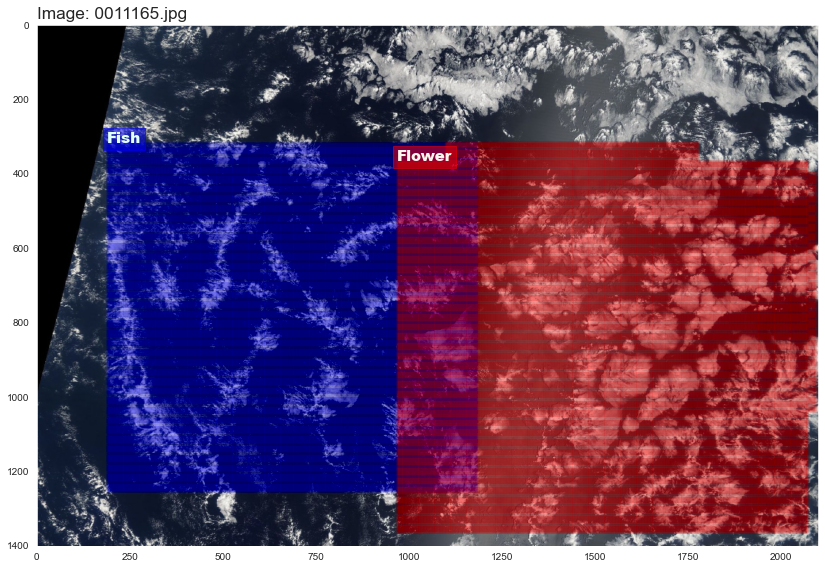



>> Cloud_Count = 2 examples: 


>>> You should see [2] areas of type Fish


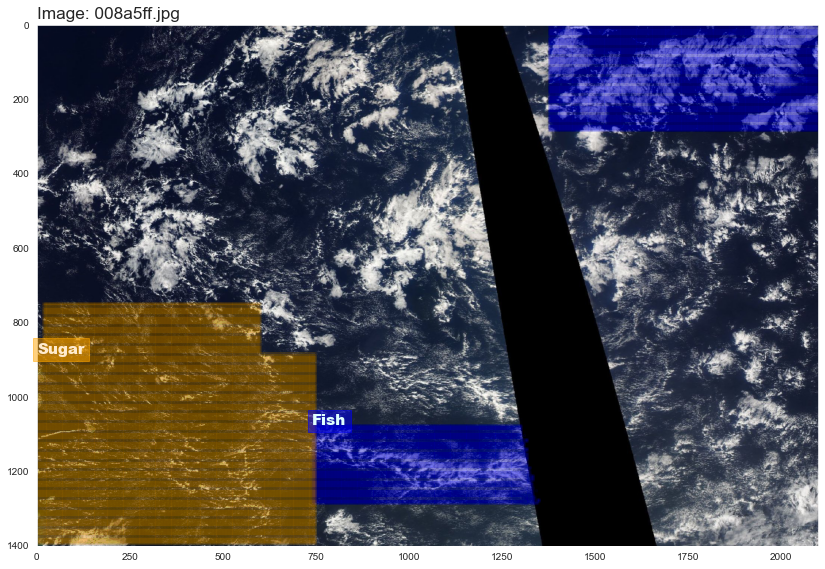



>> Cloud_Count = 3 examples: 


>>> You should see [3] areas of type Gravel


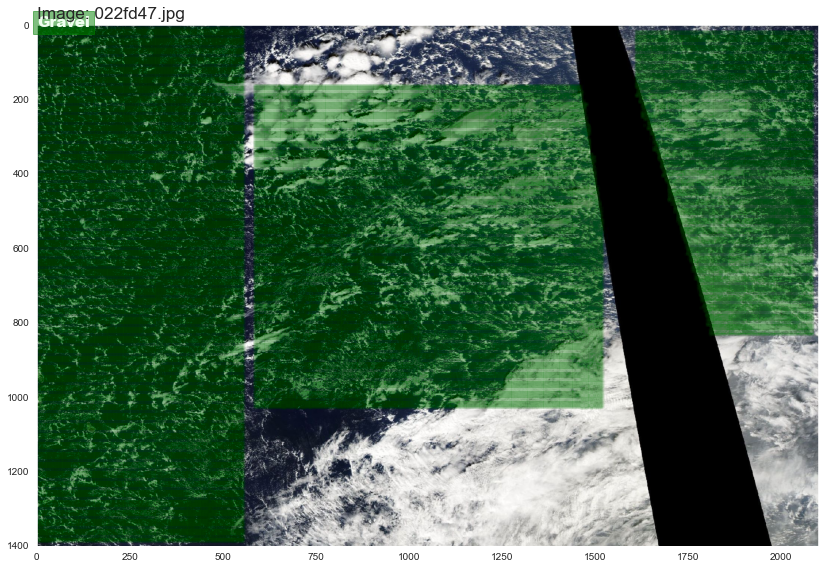



>> Cloud_Count = 4 examples: 


>>> You should see [4] areas of type Sugar


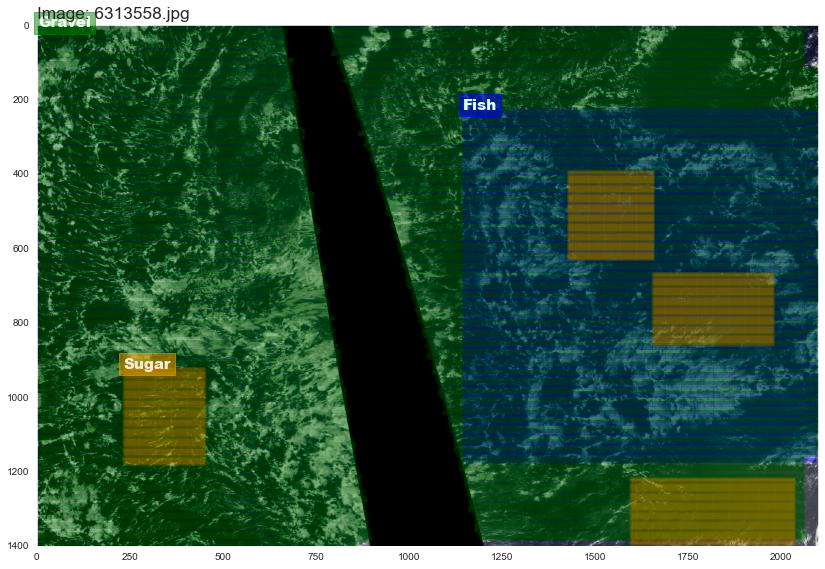

In [77]:
#Generate graphs with Graph_label_masks_from_image_list. 
#I need to indicate the path where the images are stored:
path = r'C:\Users\e400086\Desktop\Docs\DS_Certificate_Sorbonne_and_CV\02_Project_Cloud_Regions\01_Data\train_images'

# >>> [flag to reduce the number of output graph. Change to 1 to see everything]
flag_print_n_at_a_time = 5 

for cld_cnt in Images_list:
    print('\n')
    print(">> Cloud_Count = "+str(cld_cnt)+" examples: ")
    print('\n')
    L_img, L_img_labels = Images_list[cld_cnt]
    for img_idx in range(0, len(L_img), flag_print_n_at_a_time):
        print(">>> You should see ["+str(cld_cnt)+"] areas of type "+str(L_img_labels[img_idx]))
        Graph_label_masks_from_image_list([L_img[img_idx]], path, df)

### Analysis 1 -  `Cloud_Label` distribution (sum over `Cloud_Count`)

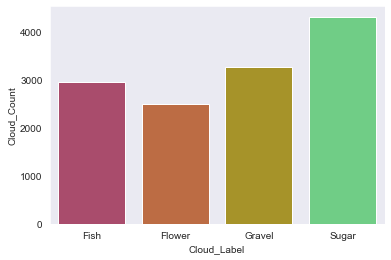

In [31]:
CC_total = df.groupby('Cloud_Label').agg({'Cloud_Count':'sum'})
CC_total = CC_total.reset_index()
ax = sns.barplot(x='Cloud_Label', y='Cloud_Count', data=CC_total, palette='tropical')

### Analysis 2 - `Cloud_Count` distribution per `Cloud_Label`

Cloud_Count [mean]
Cloud_Label                    
Fish                   0.532816
Flower                 0.448792
Gravel                 0.590516
Sugar                  0.778219

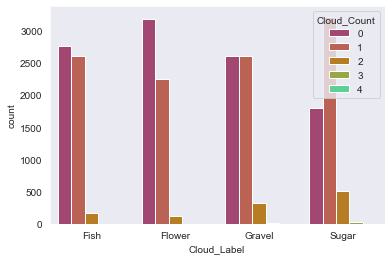

In [86]:
x = df.Cloud_Count.value_counts(normalize=True, sort=False).index.tolist()
y = df.Cloud_Count.value_counts(normalize=True, sort=False).tolist()
ax = sns.countplot(data=df, x='Cloud_Label', hue='Cloud_Count', palette='tropical')
CC_mean = df.groupby('Cloud_Label').agg({'Cloud_Count':'mean'})
CC_mean = CC_mean.rename({'Cloud_Count':'Cloud_Count [mean]'}, axis=1)
CC_mean

The distribution of `Flower` is more skewed to the left (lowest average value), while the `Sugar` distribution is more skewed to the right (highest average value).

### Analysis 3 - `Cloud_Count` correlations

In [506]:
#Build df to easily compute the correlations between all cloud labels:
df_Fish = df[df.Cloud_Label == 'Fish'].sort_values(by='Image_File').rename({'Cloud_Count':'Cloud_Count_Fish'}, axis=1)
df_Fish = df_Fish[['Image_File', 'Cloud_Count_Fish']]
df_Fish.reset_index(inplace=True, drop=True)
df_Flower = df[df.Cloud_Label == 'Flower'].sort_values(by='Image_File').rename({'Cloud_Count':'Cloud_Count_Flower'}, axis=1)
df_Flower = df_Flower[['Image_File', 'Cloud_Count_Flower']]
df_Flower.reset_index(inplace=True, drop=True)
df_Gravel = df[df.Cloud_Label == 'Gravel'].sort_values(by='Image_File').rename({'Cloud_Count':'Cloud_Count_Gravel'}, axis=1)
df_Gravel = df_Gravel[['Image_File', 'Cloud_Count_Gravel']]
df_Gravel.reset_index(inplace=True, drop=True)
df_Sugar = df[df.Cloud_Label == 'Sugar'].sort_values(by='Image_File').rename({'Cloud_Count':'Cloud_Count_Sugar'}, axis=1)
df_Sugar = df_Sugar[['Image_File', 'Cloud_Count_Sugar']]
df_Sugar.reset_index(inplace=True, drop=True)
df_Labels = pd.concat([df_Fish, df_Flower, df_Gravel, df_Sugar], axis=1)

#Compute and show correlations:
df_Labels.corr()

Cloud_Count_Fish  Cloud_Count_Flower  Cloud_Count_Gravel  \
Cloud_Count_Fish            1.000000           -0.098302           -0.028782   
Cloud_Count_Flower         -0.098302            1.000000           -0.219222   
Cloud_Count_Gravel         -0.028782           -0.219222            1.000000   
Cloud_Count_Sugar          -0.046850           -0.142623            0.093979   

                    Cloud_Count_Sugar  
Cloud_Count_Fish            -0.046850  
Cloud_Count_Flower          -0.142623  
Cloud_Count_Gravel           0.093979  
Cloud_Count_Sugar            1.000000

The lowest correlation appears between `Gravel` and `Flower`. The only positive correlation occurs between `Sugar` and `Gravel`, perhaps because the two types are the most similar of all four. The overall negative correlations can be explained intuitively by the limited image area: if a cloud type already occupies part of the image, it's less likely that other clouds exists (less unoccupied area).